# Walmart Sales Analysis
This notebook prepares the Walmart weekly sales dataset for analysis and answers the following business questions:

1. Which holidays affect weekly sales the most?
2. Which stores in the dataset have the lowest and highest unemployment rate?  What factors could be impacting the unemployment rate?
3. Is there any correlation between CPI and Weekly Sales?  How does the correlation differ during a holiday?
4. What conclusions can be made about Fuel Price compared to any of the other fields?

### Import Libraries and Data

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.set_option("display.float_format", "{:,.2f}".format)
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

In [44]:
data_path = "walmart_sales.csv"
raw_df = pd.read_csv(data_path)

print(f"Rows: {raw_df.shape[0]:,}  Columns: {raw_df.shape[1]}")
raw_df.head()

Rows: 6,435  Columns: 8


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,1,12-02-2010,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,1,19-02-2010,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,1,26-02-2010,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,1,05-03-2010,"1,554,806.68",0,46.50,2.62,211.35,8.11


In [45]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,"6,435.00",23.00,12.99,1.00,12.00,23.00,34.00,45.00
Weekly_Sales,"6,435.00","1,046,964.88","564,366.62","209,986.25","553,350.10","960,746.04","1,420,158.66","3,818,686.45"
Holiday_Flag,"6,435.00",0.07,0.26,0.00,0.00,0.00,0.00,1.00
Temperature,"6,435.00",60.66,18.44,-2.06,47.46,62.67,74.94,100.14
Fuel_Price,"6,435.00",3.36,0.46,2.47,2.93,3.44,3.73,4.47
CPI,"6,435.00",171.58,39.36,126.06,131.74,182.62,212.74,227.23
Unemployment,"6,435.00",8.00,1.88,3.88,6.89,7.87,8.62,14.31


In [46]:
print("Column data types:")
print(raw_df.dtypes)
print("Missing values per column:")
print(raw_df.isna().sum())

Column data types:
Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object
Missing values per column:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


### Data Cleaning Approach
1. Parse `Date` as a datetime, then sort by `Store` and `Date` (ascending).
2. Format `Date` as `MM-DD-YYYY` for the cleaned output.
3. Round metrics per the brief (weekly sales & fuel price: 2 decimals, temperature: whole number, CPI & unemployment: 3 decimals).
4. Confirm there are no missing values after cleaning.

In [47]:
clean_df = raw_df.copy()

# Parse and sort dates
clean_df['Date'] = pd.to_datetime(clean_df['Date'], format='%d-%m-%Y')
clean_df = clean_df.sort_values(['Store', 'Date']).reset_index(drop=True)

# Apply rounding rules
clean_df['Weekly_Sales'] = clean_df['Weekly_Sales'].round(2)
clean_df['Temperature'] = clean_df['Temperature'].round().astype(int)
clean_df['Fuel_Price'] = clean_df['Fuel_Price'].round(2)
clean_df['CPI'] = clean_df['CPI'].round(3)
clean_df['Unemployment'] = clean_df['Unemployment'].round(3)

missing_counts = clean_df.isna().sum()
assert missing_counts.sum() == 0, "Missing values need to be addressed."

analysis_df = clean_df.copy()
clean_df_display = clean_df.copy()
clean_df_display['Date'] = clean_df_display['Date'].dt.strftime('%m-%d-%Y')

print("Missing values after cleaning:")
print(missing_counts)
clean_df_display.head()

Missing values after cleaning:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,02-05-2010,"1,643,690.90",0,42,2.57,211.10,8.11
1,1,02-12-2010,"1,641,957.44",1,39,2.55,211.24,8.11
2,1,02-19-2010,"1,611,968.17",0,40,2.51,211.29,8.11
3,1,02-26-2010,"1,409,727.59",0,47,2.56,211.32,8.11
4,1,03-05-2010,"1,554,806.68",0,46,2.62,211.35,8.11


The dataset now meets every cleaning rule. I keep `analysis_df` with a datetime `Date` column for the remaining analysis.

## Business Questions

### 1. Which holidays affect weekly sales the most?

,average_sales,median_sales,observations
Holiday_Name,,,
Thanksgiving,"1,471,273.43","1,327,536.25",90
Super Bowl,"1,079,127.99","1,015,654.60",135
Labor Day,"1,042,427.29","976,415.56",135
Christmas,"960,833.11","889,821.96",90


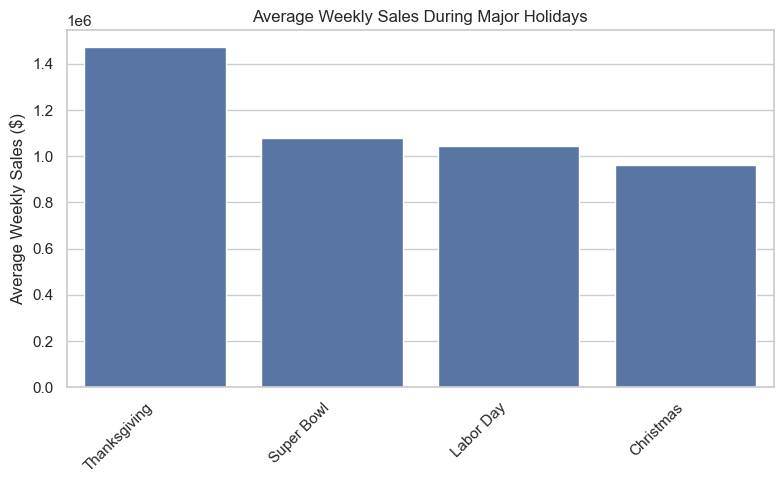

In [48]:
holiday_dates = {
    "Super Bowl": ["2010-02-12", "2011-02-11", "2012-02-10"],
    "Labor Day": ["2010-09-10", "2011-09-09", "2012-09-07"],
    "Thanksgiving": ["2010-11-26", "2011-11-25"],
    "Christmas": ["2010-12-31", "2011-12-30"],
}
holiday_lookup = {
    pd.to_datetime(date): name
    for name, dates in holiday_dates.items()
    for date in dates
}
analysis_df['Holiday_Name'] = analysis_df['Date'].map(holiday_lookup)

holiday_sales = (
    analysis_df[analysis_df['Holiday_Flag'] == 1]
    .assign(Holiday_Name=lambda d: d['Holiday_Name'].fillna('Other Holiday'))
    .groupby('Holiday_Name')['Weekly_Sales']
    .agg(average_sales='mean', median_sales='median', observations='count')
    .sort_values('average_sales', ascending=False)
)

display(holiday_sales)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=holiday_sales.reset_index(),
    x='Holiday_Name',
    y='average_sales',
    ax=ax
)
ax.set_ylabel('Average Weekly Sales ($)')
ax.set_xlabel('')
ax.set_title('Average Weekly Sales During Major Holidays')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


**Insight:** Thanksgiving weeks generate the largest average weekly sales (≈$1.47M per store), followed by Super Bowl and Labor Day periods. Christmas weeks trail the other major holidays, which suggests holiday markdowns and post-Christmas returns dampen revenue compared with Thanksgiving's peak demand.

### 2. Which stores have the lowest and highest unemployment rate? What factors appear to influence it?

In [49]:
store_unemployment = (
    analysis_df.groupby('Store')
    .agg(
        avg_unemployment=('Unemployment', 'mean'),
        min_unemployment=('Unemployment', 'min'),
        max_unemployment=('Unemployment', 'max'),
        avg_weekly_sales=('Weekly_Sales', 'mean'),
        avg_cpi=('CPI', 'mean')
    )
    .round({
        'avg_unemployment': 3,
        'min_unemployment': 3,
        'max_unemployment': 3,
        'avg_weekly_sales': 2,
        'avg_cpi': 3
    })
    .sort_values('avg_unemployment')
)

print("Stores with the lowest unemployment:")
display(store_unemployment.head(3))

print("Stores with the highest unemployment:")
display(store_unemployment.tail(3))

Stores with the lowest unemployment:


,avg_unemployment,min_unemployment,max_unemployment,avg_weekly_sales,avg_cpi
Store,,,,,
23,4.80,4.12,5.89,"1,389,864.46",135.09
40,4.80,4.12,5.89,"964,128.04",135.09
4,5.96,3.88,8.62,"2,094,712.96",128.68


Stores with the highest unemployment:


,avg_unemployment,min_unemployment,max_unemployment,avg_weekly_sales,avg_cpi
Store,,,,,
38,13.12,10.20,14.31,"385,731.65",128.68
28,13.12,10.20,14.31,"1,323,522.24",128.68
12,13.12,10.20,14.31,"1,009,001.61",128.68


Correlation of unemployment with other metrics:
CPI            -0.30
Fuel_Price     -0.04
Temperature     0.10
Weekly_Sales   -0.11
Name: Unemployment, dtype: float64


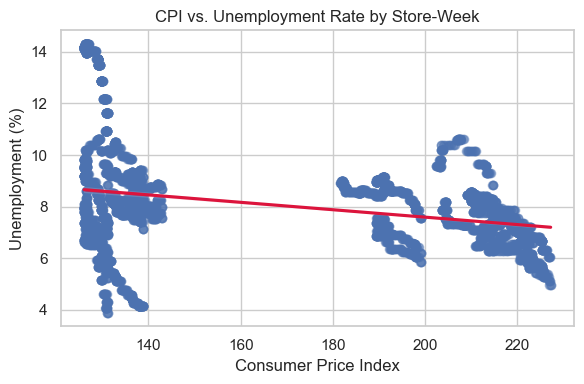

In [50]:
unemployment_corr = (
    analysis_df[['Unemployment', 'CPI', 'Fuel_Price', 'Temperature', 'Weekly_Sales']]
    .corr()
    ['Unemployment']
    .drop('Unemployment')
)
print("Correlation of unemployment with other metrics:")
print(unemployment_corr)

fig, ax = plt.subplots(figsize=(6, 4))
sns.regplot(
    data=analysis_df,
    x='CPI',
    y='Unemployment',
    scatter_kws={'alpha': 0.4},
    line_kws={'color': 'crimson'},
    ax=ax
)
ax.set_title('CPI vs. Unemployment Rate by Store-Week')
ax.set_xlabel('Consumer Price Index')
ax.set_ylabel('Unemployment (%)')
plt.tight_layout()

**Insight:** 
Stores 23 and 40 operate in areas with the lowest unemployment (≈4.8%), while stores 12, 28, and 38 sit above 13%. Unemployment correlates negatively with CPI (-0.30), implying lower-cost-of-living markets face higher unemployment, and those stores also show weaker average weekly sales. This points to broader regional economic strength (captured by CPI and sales power) as the primary driver of unemployment differences.

### 3. Is there a correlation between CPI and Weekly Sales? Does it change on holidays?

Overall CPI vs. Weekly Sales correlation: -0.0726
Non-holiday weeks: -0.0719
Holiday weeks: -0.0810


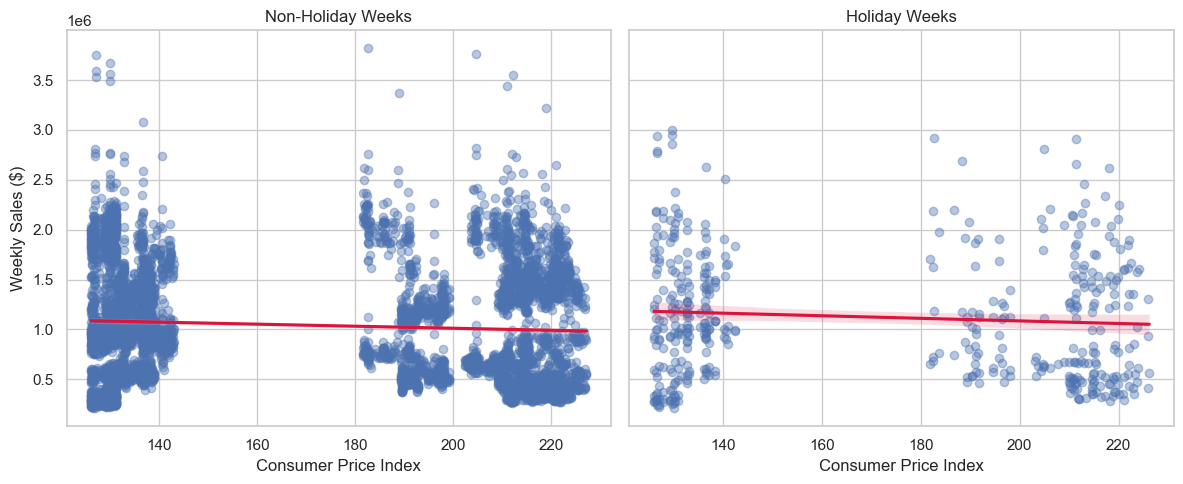

In [51]:
overall_corr = analysis_df['CPI'].corr(analysis_df['Weekly_Sales'])
corr_by_flag = {
    flag: grp['CPI'].corr(grp['Weekly_Sales'])
    for flag, grp in analysis_df.groupby('Holiday_Flag')
}

print(f"Overall CPI vs. Weekly Sales correlation: {overall_corr:.4f}")
for flag, corr in corr_by_flag.items():
    label = "Holiday weeks" if flag == 1 else "Non-holiday weeks"
    print(f"{label}: {corr:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
for ax, (flag, title) in zip(
    axes,
    [(0, 'Non-Holiday Weeks'), (1, 'Holiday Weeks')]
):
    subset = analysis_df[analysis_df['Holiday_Flag'] == flag]
    sns.regplot(
        data=subset,
        x='CPI',
        y='Weekly_Sales',
        scatter_kws={'alpha': 0.4},
        line_kws={'color': 'crimson'},
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Consumer Price Index')
    if flag == 0:
        ax.set_ylabel('Weekly Sales ($)')
    else:
        ax.set_ylabel('')
plt.tight_layout()

**Insight:** CPI has a slight negative correlation with weekly sales overall (-0.07). The relationship becomes marginally stronger in holiday weeks (-0.08 vs. -0.07), meaning stores in lower-cost markets get a small seasonal lift relative to high-cost regions, but CPI alone is not a major predictor of revenue.

### 4. Why might Fuel Price be included, and what can we conclude from it?

Correlation of fuel price with other fields:
Weekly_Sales    0.01
CPI            -0.17
Unemployment   -0.04
Name: Fuel_Price, dtype: float64


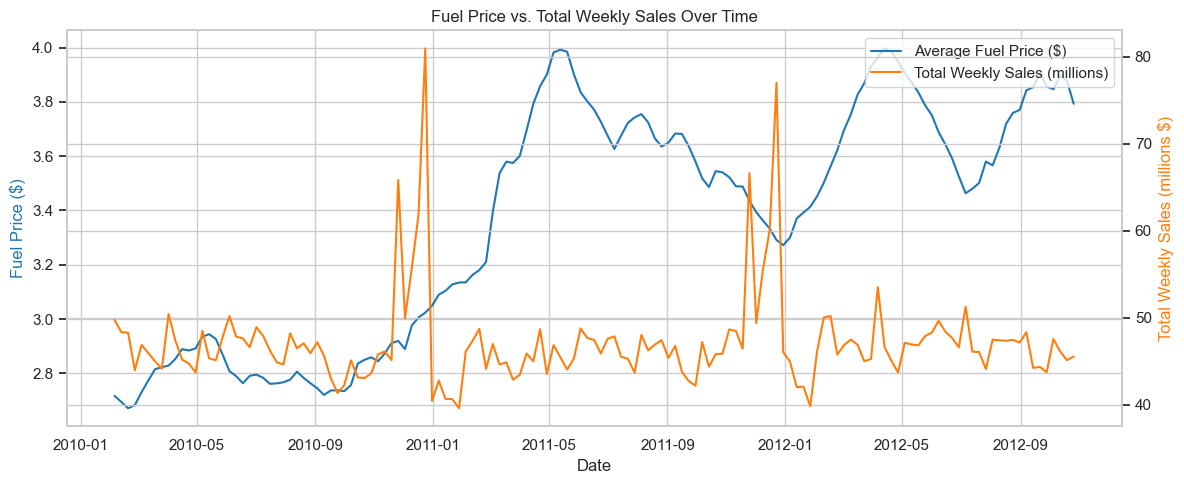

In [52]:
fuel_corr = (
    analysis_df[['Fuel_Price', 'Weekly_Sales', 'CPI', 'Unemployment']]
    .corr()
    ['Fuel_Price']
    .drop('Fuel_Price')
)
print("Correlation of fuel price with other fields:")
print(fuel_corr)

fuel_sales = (
    analysis_df.groupby('Date', as_index=False)
    .agg(
        total_weekly_sales=('Weekly_Sales', 'sum'),
        avg_fuel_price=('Fuel_Price', 'mean')
    )
)

fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()
ax1.plot(fuel_sales['Date'], fuel_sales['avg_fuel_price'], color='tab:blue', label='Average Fuel Price ($)')
ax2.plot(fuel_sales['Date'], fuel_sales['total_weekly_sales'] / 1_000_000, color='tab:orange', label='Total Weekly Sales (millions)')

ax1.set_xlabel('Date')
ax1.set_ylabel('Fuel Price ($)', color='tab:blue')
ax2.set_ylabel('Total Weekly Sales (millions $)', color='tab:orange')
ax1.set_title('Fuel Price vs. Total Weekly Sales Over Time')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()

**Insight:** Fuel price shows almost no direct correlation with weekly sales (0.01) but is moderately tied to CPI (-0.17). Including fuel data helps capture macroeconomic conditions—periods of cheaper fuel often coincide with lower CPI regions that already face higher unemployment. Monitoring fuel price is therefore useful for understanding customers' discretionary spending power even if it doesn't move sales on its own.

## Key Takeaways
- Thanksgiving delivers the strongest holiday sales lift, while Christmas lags, likely due to discounts/returns.
- Regional economic strength (captured by CPI and unemployment) explains most store-to-store differences; stores in high-unemployment markets consistently trail in sales.
- CPI has only a mild relationship with sales, and fuel price is better viewed as a macro signal than a direct driver of weekly revenue.